In [34]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np


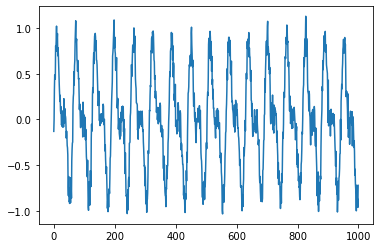

In [35]:
#make model 
N = 1000
x = np.arange(N)
series = 0.6*np.sin(0.1*x) +0.4*np.sin(0.2*x) + np.random.normal(0,0.1,N)

plt.plot(series)
plt.show()

In [36]:
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
class RNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_rnnlayers, num_outputs):
        super(RNN, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_rnnlayers = num_rnnlayers
        self.num_outputs = num_outputs
        self.rnn = nn.RNN(
            input_size=num_inputs,
            hidden_size=self.num_hidden,
            num_layers=self.num_rnnlayers,
            nonlinearity='relu',
            batch_first=True)
        self.fc = nn.Linear(self.num_hidden, self.num_outputs)
    def forward(self,x):
        h0 = torch.zeros(self.num_rnnlayers, x.size(0), self.num_hidden).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
model = RNN(num_inputs=1, num_hidden=20, num_rnnlayers=2, num_outputs=1)
model.to(device)


RNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [39]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [41]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=1000):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
  return train_losses, test_losses

In [42]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

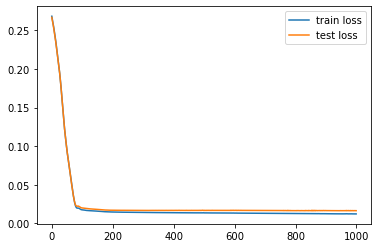

In [43]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

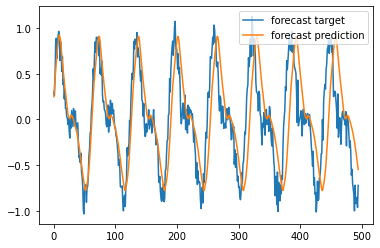

In [44]:
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p[0,0].item())
  
  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()